<a href="https://colab.research.google.com/github/zpenct/Social-Network-Analysis/blob/main/Playground_SNA_%5BTOP_%2B_LATEST%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stop_words
!pip install squarify

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32894 sha256=aad2808b2b9cab028174b7919cadb21f52f9e470a9ddb602bf07db1b1a62745c
  Stored in directory: /root/.cache/pip/wheels/8f/a5/51/a5405e1da5d178491b79d12cc81b6cb9bb14fe2c8c632eba70
Successfully built stop_words


In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from collections import defaultdict

In [ ]:
import re

# --- STOPWORDS BAHASA INDONESIA ---
stopwords_id = set([
    'yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'untuk', 'dengan',
    'juga', 'ada', 'karena', 'pada', 'tidak', 'sudah', 'saja', 'oleh',
    'kami', 'kita', 'mereka', 'saya', 'aku', 'anda', 'atau', 'tapi', 'lagi',
    'agar', 'bagi', 'sebagai', 'adalah', 'dalam', 'dia', 'ia', 'yah', 'oh',
    'eh', 'ah', 'pun', 'ya', 'kok', 'kan', 'lah', 'dong', 'nih', 'deh', 'vs', 'VS','Vs', 'lalu','akan','sampai','bisa','apa','antara','apakah','dgn','link','gak','akun','pas','aja','padahal', 'uniqlo', 'jaket', 'uv'
])

# --- CLEANING + STOPWORD REMOVAL ---
def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = text.strip()
    text = re.sub(r'@\w+', '', text)  # Hapus mention
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag
    text = re.sub(r'http\S+|www.\S+', '', text)  # Hapus link
    text = re.sub(r'[^\w\s,.!?]', '', text, flags=re.UNICODE)  # Hapus emoji/simbol
    text = re.sub(r'\s+', ' ', text)  # Hapus spasi berlebih

    # Hapus stopword
    tokens = text.split()
    filtered = [word for word in tokens if word not in stopwords_id and len(word) > 2 and not word.isdigit()]
    return ' '.join(filtered)

# Load dataset hasil scraping
df = pd.read_csv("infinixhot.csv")

df= df.drop_duplicates(subset="full_text")

# Terapkan pembersihan
df['cleaned_text'] = df['full_text'].apply(clean_text)

# --- EXTRACT EDGES (mention, reply, retweet) ---
edges = []
for _, row in df.iterrows():
    source = row['username']

    # Mention
    mentions = re.findall(r'@(\w+)', row['full_text'])
    for target in mentions:
        edges.append((source, target, 'mention'))

    # Reply
    if pd.notna(row['in_reply_to_screen_name']):
        edges.append((source, row['in_reply_to_screen_name'], 'reply'))

    # Retweet
    if row['full_text'].startswith("RT @"):
        match = re.match(r"RT @(\w+)", row['full_text'])
        if match:
            edges.append((source, match.group(1), 'retweet'))

# --- EDGE LIST UNTUK GEPHI ---
edge_rows = []
for source, target, interaction in edges:
    edge_rows.append({
        'Source': source,
        'Target': target,
        'Type': 'Directed',
        'Weight': 1,
        'Interaction': interaction
    })

df_edges = pd.DataFrame(edge_rows)
df_edges = df_edges.groupby(['Source', 'Target', 'Type', 'Interaction']).agg({'Weight': 'sum'}).reset_index()

# --- NODE LIST UNTUK GEPHI ---
all_users = set(df_edges['Source']).union(set(df_edges['Target']))
df_nodes = pd.DataFrame({'Id': list(all_users)})
df_nodes['Label'] = df_nodes['Id']

# --- KUMPULKAN TEKS PER USER UNTUK TOPIK/TF-IDF ---
df_user_texts = df.groupby('username')['cleaned_text'].apply(lambda texts: ' '.join(texts)).reset_index()
df_user_texts.columns = ['Id', 'AllText']

# --- EXPORT SEMUA KE CSV ---
df_edges.to_csv("gephi_project_edges.csv", index=False)
df_nodes.to_csv("gephi_project_nodes.csv", index=False)
df_user_texts.to_csv("gephi_project_user_texts.csv", index=False)
df.to_csv("scrapped_cleaned_merged.csv", index=False)

In [ ]:
# ambil stopwords bahasa Indonesia
stopwords_id = get_stop_words('indonesian')

# vectorizer dengan stopword Indo
vectorizer = TfidfVectorizer(stop_words=stopwords_id, max_features=100)

# Load ulang data
modularity_df = pd.read_csv("exported-nodes-stats-merged.csv")
texts_df = pd.read_csv("gephi_project_user_texts.csv")

# Samakan tipe kolom Id
modularity_df["Id"] = modularity_df["Id"].astype(str)
texts_df["Id"] = texts_df["Id"].astype(str)

# Merge berdasarkan Id
merged = pd.merge(modularity_df, texts_df, on="Id")

# Gabungkan teks per komunitas
# grouped = merged.groupby("modularity_class")["AllText"].apply(lambda texts: ' '.join(texts)).reset_index()
grouped = merged.groupby("modularity_class")["AllText"].apply(
    lambda texts: ' '.join(text for text in texts.dropna().astype(str))
).reset_index()

# TF-IDF per komunitas
# vectorizer = TfidfVectorizer(stop_words='indonesian', max_features=100)
top_words = {}

for i, row in grouped.iterrows():
    comm = row["modularity_class"]
    text = row["AllText"]

    if len(text.strip()) > 0:
        X = vectorizer.fit_transform([text])
        scores = zip(vectorizer.get_feature_names_out(), X.toarray()[0])
        sorted_words = sorted(scores, key=lambda x: x[1], reverse=True)[:10]
        top_words[comm] = [word for word, score in sorted_words]
    else:
        top_words[comm] = []

# Cetak hasil topik per komunitas
for comm, words in top_words.items():
    print(f"Komunitas {comm}: {', '.join(words)}")


FileNotFoundError: [Errno 2] No such file or directory: 'exported-nodes-stats-merged.csv'

In [ ]:
# Load data dari Gephi + teks tweet
df_nodes = pd.read_csv("exported-nodes-stats-merged.csv")
df_texts = pd.read_csv("gephi_project_user_texts.csv")

# Persiapan merge
df_nodes["Id"] = df_nodes["Id"].astype(str)
df_texts["Id"] = df_texts["Id"].astype(str)

# Merge data
df_merged = pd.merge(df_nodes, df_texts, on="Id")

# Kelompokkan teks per komunitas
text_grouped = df_merged.groupby("modularity_class")["AllText"].apply(lambda texts: ' '.join(texts)).reset_index()

# TF-IDF per komunitas
vectorizer = TfidfVectorizer(stop_words=None, max_features=100)
top_words = {}

for i, row in text_grouped.iterrows():
    comm = row["modularity_class"]
    text = row["AllText"]

    if len(text.strip()) > 0:
        X = vectorizer.fit_transform([text])
        scores = zip(vectorizer.get_feature_names_out(), X.toarray()[0])
        sorted_words = sorted(scores, key=lambda x: x[1], reverse=True)[:10]
        top_words[comm] = [word for word, score in sorted_words]
    else:
        top_words[comm] = []

# Aktor utama per komunitas (berdasarkan pageranks)
top_actors = df_merged.groupby("modularity_class").apply(
    lambda g: g.sort_values(by="pageranks", ascending=False).head(5)["Id"].tolist()
).to_dict()

# Gabungkan hasil
result = []

for comm in sorted(top_words.keys()):
    result.append({
        "Komunitas": comm,
        "Wording Dominan": ', '.join(top_words.get(comm, [])),
        "Aktor Utama": ', '.join(top_actors.get(comm, []))
    })

df_result = pd.DataFrame(result)

# Simpan ke file (opsional)
df_result.to_csv("wording_dan_aktor_per_komunitas.csv", index=False)

<ipython-input-48-8b2d9427f860>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_actors = df_merged.groupby("modularity_class").apply(


In [ ]:
# Tampilkan semua kolom
pd.set_option('display.max_columns', None)

# Tampilkan semua baris
pd.set_option('display.max_rows', None)


df_result

,Komunitas,Wording Dominan,Aktor Utama
0,0,"australia, bagus, ganti, hasilnya, indonesia, ...",1404Stj
1,1,"australia, indonesia, menang, china, arab, lol...","FaktaSepakbola, AAfantu, raykairi"
2,2,"australia, indonesia, sty, menang, datang, has...","idextratime, AidilakbarHara1, Bayu_Gampo, Lel_..."
3,3,"australia, indonesia, pak, jokowi, kluivert, p...","AlanGrasilan12, BeBuzzerNKRI, ChelseaEleven, F..."
4,4,"2026, amp, apalagi, australia, bahrain, balas,...",AqsaDipta
5,5,"australia, sty, kalah, lawan, naturalisasi, pe...","ArdianWidiarto, reze_tolka"
6,6,"indonesia, australia, timnas, bahrain, hasil, ...","TimnasIndonesia, BastenGaming, GampankMonther,..."
7,7,"australia, indonesia",Brainfr26861166
8,8,"australia, indonesia","BudiSumardji, bambanxwuryanto, ramtolontong"
9,9,"menang, arab, china, saudi, australia, bahrain...",BupatiImogiri


In [ ]:
# Load data dari file CSV yang sudah di-export
df_result = pd.read_csv("wording_dan_aktor_per_komunitas.csv")

# Fungsi untuk menghitung jumlah kata dalam Wording Dominan
def count_words(topic_str):
    return len(str(topic_str).split(', '))

# Fungsi untuk menghitung jumlah aktor
def count_actors(actor_str):
    return len(str(actor_str).split(', '))

df_result['Jumlah_Wording'] = df_result['Wording Dominan'].apply(count_words)
df_result['Jumlah_Aktor'] = df_result['Aktor Utama'].apply(count_actors)

# Ekstrak Wording utama dari setiap komunitas (ambil kata pertama sebagai representasi)
df_result['Wording_Utama'] = df_result['Wording Dominan'].apply(lambda x: str(x).split(', ')[0] if pd.notna(x) else "")

# Buat visualisasi dengan beberapa subplot
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.5])

# Warna-warna yang dapat digunakan
colors = plt.cm.viridis(np.linspace(0, 1, len(df_result)))
color_dict = {row['Komunitas']: colors[i] for i, (_, row) in enumerate(df_result.iterrows())}

# 1. Grafik Network untuk visualisasi hubungan antar komunitas
plt.subplot(gs[0, 0])
G = nx.Graph()

# Tambahkan node untuk setiap komunitas
for _, row in df_result.iterrows():
    G.add_node(row['Komunitas'],
               size=row['Jumlah_Wording'] * 100,
               color=color_dict[row['Komunitas']])

# Buat edge berdasarkan kesamaan Wording
for i, row1 in df_result.iterrows():
    for j, row2 in df_result.iterrows():
        if i < j:  # hindari duplikasi
            topics1 = set(str(row1['Wording Dominan']).split(', '))
            topics2 = set(str(row2['Wording Dominan']).split(', '))
            common_topics = topics1.intersection(topics2)
            if len(common_topics) > 0:
                G.add_edge(row1['Komunitas'], row2['Komunitas'],
                           weight=len(common_topics),
                           alpha=min(0.1 + len(common_topics)/10, 1))

# Gambar graph
pos = nx.spring_layout(G, seed=42)
node_sizes = [G.nodes[node]['size'] for node in G.nodes()]
node_colors = [G.nodes[node]['color'] for node in G.nodes()]

edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_alphas = [G[u][v]['alpha'] for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title('Jaringan Komunitas berdasarkan Kesamaan Wording', fontsize=16)
plt.axis('off')

# 2. Treemap untuk visualisasi proporsi komunitas berdasarkan jumlah Wording
plt.subplot(gs[0, 1])
squarify_data = df_result['Jumlah_Wording'].values
labels = [f"Kom. {row['Komunitas']}" for _, row in df_result.iterrows()]

# Membuat custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

from matplotlib import cm
import squarify

# Pastikan nilai tidak negatif dan tidak nol untuk squarify
positive_data = np.maximum(squarify_data, 0.1)

squarify.plot(sizes=positive_data,
              label=labels,
              alpha=0.8,
              color=colors,
              pad=0.02)
plt.title('Proporsi Komunitas berdasarkan Jumlah Wording', fontsize=16)
plt.axis('off')

# 3. Top 10 Komunitas berdasarkan Jumlah Aktor
plt.subplot(gs[1, 0])
df_top10 = df_result.sort_values(by='Jumlah_Aktor', ascending=False).head(10)
sns.barplot(x='Komunitas', y='Jumlah_Aktor', data=df_top10, palette=colors)
plt.title('Top 10 Komunitas berdasarkan Jumlah Aktor', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

# 4. Top 10 Komunitas berdasarkan Jumlah Wording
plt.subplot(gs[1, 1])
df_top10_topics = df_result.sort_values(by='Jumlah_Wording', ascending=False).head(10)
sns.barplot(x='Komunitas', y='Jumlah_Wording', data=df_top10_topics, palette=colors)
plt.title('Top 10 Komunitas berdasarkan Jumlah Wording', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

# 5. Word Cloud untuk Wording dominan global
plt.subplot(gs[2, :])
all_topics = ' '.join([str(topic) for topic in df_result['Wording Dominan'].tolist() if pd.notna(topic)])

# Buat wordcloud
wordcloud = WordCloud(width=1200, height=400,
                      background_color='white',
                      colormap='viridis',
                      contour_width=1,
                      contour_color='steelblue').generate(all_topics)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud Wording Dominan Seluruh Komunitas', fontsize=16)
plt.axis('off')

plt.tight_layout(pad=4.0)
plt.savefig('visualisasi_komunitas.png', dpi=300, bbox_inches='tight')
plt.close()

<ipython-input-50-8e4a5c63020c>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Komunitas', y='Jumlah_Aktor', data=df_top10, palette=colors)
<ipython-input-50-8e4a5c63020c>:88: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x='Komunitas', y='Jumlah_Aktor', data=df_top10, palette=colors)
<ipython-input-50-8e4a5c63020c>:88: UserWarning: The palette list has more values (100) than needed (10), which may not be intended.
  sns.barplot(x='Komunitas', y='Jumlah_Aktor', data=df_top10, palette=colors)
<ipython-input-50-8e4a5c63020c>:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Komu

### **Distribusi Jumlah Tweet per Komunitas**

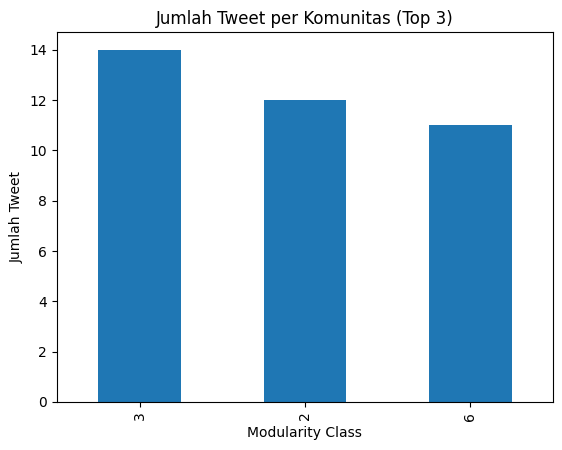

In [ ]:
df_merged['modularity_class'].value_counts().head(3).plot(kind='bar', title='Jumlah Tweet per Komunitas (Top 3)')
plt.xlabel('Modularity Class')
plt.ylabel('Jumlah Tweet')
plt.show()

In [ ]:

modularity_df = pd.read_csv("exported-nodes-stats-merged.csv")

tweets_df = pd.read_csv("scrapped_cleaned_merged.csv", encoding="ISO-8859-1", quoting=csv.QUOTE_MINIMAL, on_bad_lines='skip')

modularity_df['Id'] = modularity_df['Id'].astype(str)
tweets_df['username'] = tweets_df['username'].astype(str)

merged_df = pd.merge(tweets_df, modularity_df[['Id', 'modularity_class']], left_on='username', right_on='Id', how='inner')

top_communities = merged_df['modularity_class'].value_counts().head(3).index.tolist()

top_communities_df = merged_df[merged_df['modularity_class'].isin(top_communities)]

top_communities_df[['modularity_class', 'username', 'full_text']].to_csv("top3_komunitas_tweets.csv", index=False)

### **Top Tweet dengan Engagement Tertinggi**

In [ ]:
top_engagement = merged_df.copy()
top_engagement['engagement'] = top_engagement['retweet_count'] + top_engagement['reply_count'] + top_engagement['favorite_count']
top10 = top_engagement.sort_values(by='engagement', ascending=False).head(10)
display(top10[['username', 'full_text', 'engagement']])


,username,full_text,engagement
7,ainurohman,Bahkan media nan jauh di sana tahu bahwa ini a...,16423
21,gilabola_ina,Kevin Diks diwawancarai oleh media Denmark usa...,8984
3,gilabola_ina,Timnas futsal Indonesia di bawah asuhan Hector...,5260
81,idextratime,Update kondisi Sandy Walsh dan Mees Hilgers y...,4368
255,ainurohman,HT Australiað¦ðº vs Indonesiað®ð© 3-0....,3392
10,eeepan,Sangking buruknya kekalahan Timnas Indonesia v...,2749
43,FaktaSepakbola,ð®ð©Kekalahan Indonesia vs Australia menja...,2291
36,FaktaSepakbola,Shin Tae-yong mengadakan nobar Timnas Indonesi...,1858
68,idextratime,RESMI : Los Angeles FC memberikan debut kepad...,1390
61,idextratime,Ian Maatsen akan menjalani debut langsung sta...,1005
